### Implementation of $\mathbb P_1$ FEM in 1D

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
import scipy.integrate as integrate


In [2]:
Xk = np.array([0, 0.1, 0.3, 0.6, 0.8, 0.9, 0.95, 0.97, 1])  # Nodes, elements K(i) = (x(i-1), x(i))
Xk = np.concatenate(([0],np.sort(np.random.random(20)),[1]))
Xk = np.around(np.concatenate(([0],np.sort(np.random.random(20)),[1])), decimals=3)  # For printing out smaller A-matrix
Mi = len(Xk)                     # Number of nodes
T = np.ndarray.transpose(np.array([Xk[:-1],Xk[1:]])) # Set of elements/triangulation
H = Xk[1:]-Xk[:-1]               # Element sizes
Mk = Mi-1                        # Number of elements
a,b,c = 1,1,1
np.random.seed(420)

In [3]:
def matprint(mat, fmt="g"):
    """prints matrix in a nicer format"""
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [4]:
def u1(x):
    return np.sin(10*x*np.pi)

def du1(x):
    """
    First derivative of u used to measure H1 norm
    """
    return 10*np.pi*np.cos(10*np.pi*x)

def ddu1(x):
    """
    Second derivative of u used to measure H2 norm
    """
    return - 100 * np.pi**2 * np.sin(10*np.pi*x)

def f1(x):
    return a * 100 *(np.pi**2)* np.sin(10*x*np.pi) + 10*b*np.cos(10*x*np.pi)*np.pi + c*np.sin(10*x*np.pi)

def u2(x):
    return x*(1-x)

def du2(x):
    return 1-2*x

def ddu2(x):
    return -2*np.ones(len(x))

def f2(x):
    return 2*a + b*(1-2*x) + c*x*(1-x)

Set up the elemental stiffness matrix and elemental load vector).

In [5]:
def Ak(k):
    return np.array([[a/H[k]+c*H[k]/3,-a/H[k+1] + 0.5*b + (1/6)*c*H[k+1]],[-a/H[k+1] - 0.5*b + (1/6)*c*H[k+1],a/H[k]+c*H[k]/3]])

def phi(x, i, nodes):
    if i == len(nodes) - 1:
        geq = x >= nodes[i-1]
        leq = x <= nodes[i]
        leftElement = geq * leq
        return (x - nodes[i-1]) / (nodes[i] - nodes[i-1]) * leftElement
    geq = x >= nodes[i-1]
    leq = x < nodes[i]
    leftElement = geq * leq
    geq = x >= nodes[i]
    leq = x < nodes[i+1]
    rightElement = geq * leq
    return (x - nodes[i-1]) / (nodes[i] - nodes[i-1]) * leftElement + (nodes[i+1] - x) / (nodes[i+1] - nodes[i]) * rightElement

def dphi(x, i, nodes):
    if i == len(nodes) - 1:
        geq = x >= nodes[i-1]
        leq = x <= nodes[i]
        leftElement = geq * leq
        return 1 / (nodes[i] - nodes[i-1]) * leftElement
    geq = x >= nodes[i-1]
    leq = x < nodes[i]
    leftElement = geq * leq
    geq = x >= nodes[i]
    leq = x < nodes[i+1]
    rightElement = geq * leq
    return 1 / (nodes[i] - nodes[i-1]) * leftElement - 1 / (nodes[i+1] - nodes[i]) * rightElement


In [6]:
# Compute RHS F:
def F1(x, i, nodes):
    '''
    f(x) * phi_i(x)
    '''
    return f1(x) * phi(x, i, nodes)

def F2(x, i, nodes):
    return f2(x) * phi(x, i, nodes)

The assembly process:

In [7]:
def assemble(Xk,H):
    A = np.zeros((len(Xk)-2,len(Xk)-2))

    for i in range(1,len(A)-1): #Problems at 0 and len(A) with j-loop
        for j in range(i-1,i+2): 
            if i == j: #Diagonal
                A[i,j] = a/H[i] + c*H[i]/3 + a/H[i+1]+c*H[i+1]/3
            elif (j == i-1): #Subdiagonal
                A[i,j] = -a/H[i] - 0.5*b + (1/6)*c*H[i]
            elif (j == i+1): #Above diagonal
                A[i,j] = -a/H[i+1] + 0.5*b + (1/6)*c*H[i+1]

    A[0,0] = a/H[0]+c*H[0]/3 + a/H[1]+c*H[1]/3
    A[0,1] = -a/H[1] + 0.5*b + (1/6)*c*H[1]
    A[-1,-1] = a/H[-2]+c*H[-2]/3 + a/H[-1]+c*H[-1]/3
    A[-1,-2] = -a/H[-2] - 0.5*b + (1/6)*c*H[-2]
    return A


Impose the boundary conditions by changing the first and the last equation. 

In [8]:
def setup_RHS(Xk,H,u,F):
    RHS = np.zeros(len(Xk)-2)
    for i in range(len(RHS)):
        RHS[i] = integrate.quad(F, Xk[i], Xk[i+2], args=(i+1, Xk))[0]
        #RHS[i] = integrate.trapezoid(f(Xk)*phi(Xk,i+1,Xk),x=Xk)

    RHS[0] += u(0) * (a/H[0] + b/2 - 1/6*c*H[0])
    RHS[-1] += u(1) * (a/H[-1] - b/2 - 1/6*c*H[-1])
    return RHS

And solve the corresponding linear system

In [9]:
A = assemble(Xk,H)
RHS = setup_RHS(Xk,H,u1,F1)
U = np.linalg.solve(A,RHS)
U = np.concatenate(([u1(0)],U,[u1(1)]))

print("Nodes: ", Xk)
print("\n\nStiffness matrix: \n")
matprint(A)

Nodes:  [0.    0.048 0.142 0.281 0.29  0.305 0.37  0.464 0.529 0.543 0.544 0.591
 0.618 0.644 0.679 0.718 0.783 0.868 0.903 0.923 0.986 1.   ]


Stiffness matrix: 

  31.519  -10.1226         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0  
-11.1226   17.9102  -6.67108         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0  
       0  -7.67108   118.355   -110.61         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0  
       0         0   -111.61   177.786  -66.1642         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0  
       0         0         0  -

Plot the solution. 

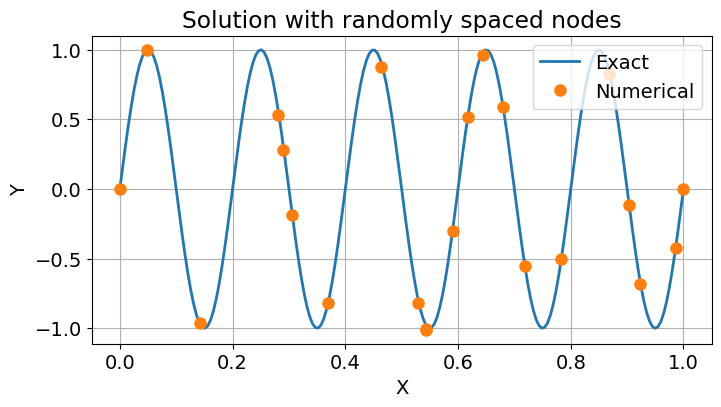

In [10]:
x = np.linspace(0,1,200)
plt.figure()
plt.title("Solution with randomly spaced nodes")
plt.plot(x,u1(x),Xk,U,'o')
plt.legend(['Exact','Numerical'],loc=1)
plt.xlabel('X')
plt.ylabel("Y")
plt.show()

In [11]:
def converge(F,u,du,norm = "L2"):
    K = 5
    H_vals = np.zeros(K)
    E_vals = np.zeros(K)
    number_of_nodes = 20
    x = np.linspace(0, 1, 1000) # Interpolation grid
    for k in range(K):
        #Set up and solve linear system
        nodes = np.linspace(0,1,number_of_nodes)
        H = np.diff(nodes)
        A = assemble(nodes,H)

        RHS = setup_RHS(nodes,H,u,F)

        coeffs = np.linalg.solve(A, RHS)

        Coeffs = np.concatenate(([u(0)], coeffs, [u(1)]))

        U = np.zeros(len(x))
        dU = np.zeros(len(x)) # derivative of numerical solution used for H_1 norm
        for i in range(len(Coeffs)):
            U += Coeffs[i] * phi(x, i, nodes)
            dU += Coeffs[i] * dphi(x, i, nodes)


        #Measure + store error and stepsize
        if norm == "L2":
            error = integrate.simpson((u(x)-U)[1:-1]**2, x[1:-1])**(1/2)
        elif norm == "H1": # HER FÅR VI ORDEN 1 DERSOM VI TAR INVERSEN AV NORMEN ISTEDENFOR?
            error = (integrate.simpson((u(x)-U)[1:-1]**2, x[1:-1]) + integrate.simpson((du(x)-dU)[1:-1]**2, x[1:-1]))**(1/2)
            # Error bound:
            # H2_error = (integrate.simpson(u(nodes)**2, nodes) + integrate.simpson(du(nodes)**2, nodes) + integrate.simpson(ddu(nodes)**2, nodes))**(1/2)
        H_vals[k] = H[0]
        E_vals[k] = error

        number_of_nodes *= 2
    order = np.polyfit(np.log(H_vals),np.log(E_vals),1)[0]
    return H_vals, E_vals, order

In [12]:
def theoretical_bounds(f,x,h,ddu,a=1,b=1,c=1):
    #H1 error bound
    M = a + b + c + integrate.simpson((f(x))**2, x)**(1/2) #Continuity constant
    alpha = np.minimum(a/2,c - (np.abs(b)**2)/(2*a)) #Coercivity constant

    return (2*M/alpha) * integrate.simpson((ddu(x))**2, x)**(1/2) * h


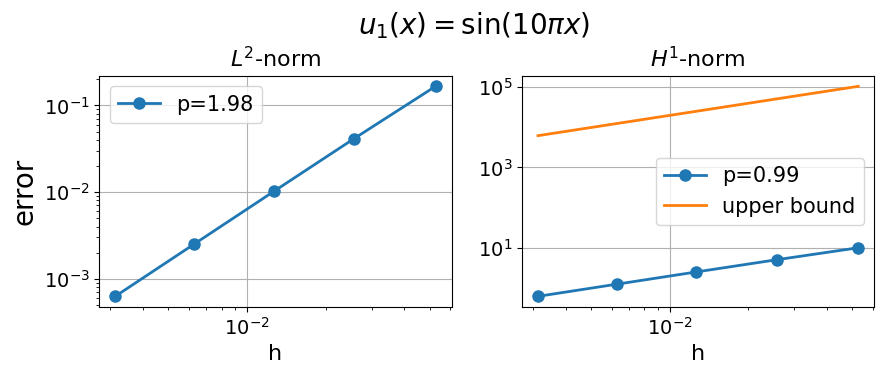

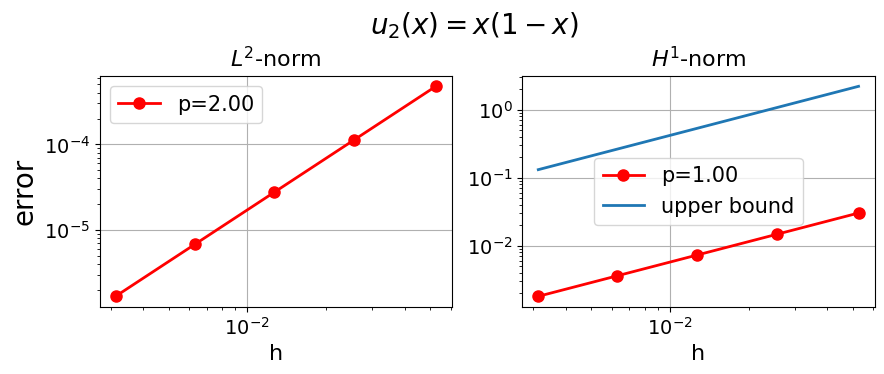

In [13]:
fig,axes = plt.subplots(1, 2, figsize=(10,3))

fig.suptitle(r"$u_1(x) = \sin(10 \pi x)$", fontsize=20, y=1.1)

h,e,o = converge(F1,u1,du1,norm="L2")

axes[0].set_title(r"$L^2$-norm", fontsize=16)
axes[0].loglog(h,e,'o-', label='p={:.2f}'.format(o))
axes[0].grid('on')
axes[0].set_xlabel('h', fontsize=16)
axes[0].set_ylabel('error', fontsize=20)
axes[0].legend(fontsize=15)

h,e,o = converge(F1,u1,du1,norm="H1")
x = np.linspace(0,1,1000)
H1_bound = theoretical_bounds(f1,x,h,ddu1)

axes[1].set_title(r"$H^1$-norm", fontsize=16)
axes[1].loglog(h,e,'o-', label='p={:.2f}'.format(o))
axes[1].loglog(h, H1_bound, label="upper bound") # upper bound
axes[1].grid('on')
axes[1].set_xlabel('h', fontsize=16)
axes[1].legend(fontsize=15)

plt.savefig("Convergence1.png",bbox_inches='tight')
fig.show()

h,e,o = converge(F2,u2,du2,norm="L2")

fig,axes = plt.subplots(1, 2, figsize=(10,3))

fig.suptitle(r"$u_2(x) = x(1-x)$", fontsize=20, y=1.1)

axes[0].set_title(r"$L^2$-norm", fontsize=16)
axes[0].loglog(h,e,'o-', label='p={:.2f}'.format(o), color="red")
axes[0].grid('on')
axes[0].set_xlabel('h', fontsize=16)
axes[0].set_ylabel('error', fontsize=20)
axes[0].legend(fontsize=15)

h,e,o = converge(F2,u2,du2,norm="H1")
H1_bound = theoretical_bounds(f2,x,h,ddu2)

axes[1].set_title(r"$H^1$-norm", fontsize=16)
axes[1].loglog(h,e,'o-', label='p={:.2f}'.format(o), color="red")
axes[1].loglog(h,H1_bound,label = "upper bound")
axes[1].grid('on')
axes[1].set_xlabel('h', fontsize=16)
axes[1].legend(fontsize=15)

plt.savefig("Convergence2.png",bbox_inches='tight')
fig.show()

[0.   0.03 0.06 0.1  0.13 0.16 0.19 0.2  0.31 0.43 0.54 0.66 0.77 0.89
 1.  ]
[0.   0.03 0.06 0.1  0.13 0.16 0.19 0.2  0.31 0.43 0.54 0.66 0.77 0.89
 1.  ]
[0.   0.07 0.14 0.21 0.29 0.36 0.43 0.5  0.57 0.64 0.71 0.79 0.86 0.93
 1.  ]


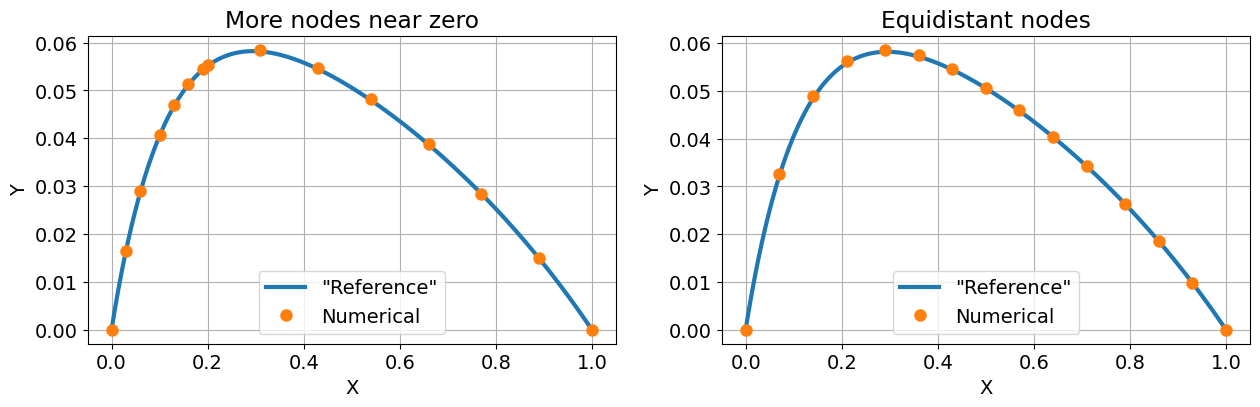

In [14]:
# 2e)
a, b, c = 1,-5,14

def f3(x):
    return x**(-1/4)

def u3(x):
    return 0

def F3(x, i, nodes):
    return f3(x) * phi(x, i, nodes)



# Test with a lot more nodes near 0
X_near_zero = np.around(np.concatenate((np.linspace(0,0.19,7), np.linspace(0.2,1,8))),decimals=2)
print(X_near_zero)
#X_near_zero = np.array([0,0.01,0.02,0.035,0.05,0.07,0.09,0.11,0.3,0.5,0.7,0.9,1])
H = X_near_zero[1:]-X_near_zero[:-1]
A_near_zero = assemble(X_near_zero,H)
RHS_near_zero = setup_RHS(X_near_zero,H, u3, F3)
U_near_zero = np.linalg.solve(A_near_zero,RHS_near_zero)
U_near_zero = np.concatenate(([u3(0)],U_near_zero,[u3(1)]))

# Test with a lot more nodes nearer 0
X_nearer_zero = np.around(np.concatenate((np.linspace(0,0.1,7), np.linspace(0.12,1,8))),decimals=2)
print(X_near_zero)
#X_near_zero = np.array([0,0.01,0.02,0.035,0.05,0.07,0.09,0.11,0.3,0.5,0.7,0.9,1])
H = X_nearer_zero[1:]-X_nearer_zero[:-1]
A_nearer_zero = assemble(X_nearer_zero,H)
RHS_nearer_zero = setup_RHS(X_nearer_zero,H, u3, F3)
U_nearer_zero = np.linalg.solve(A_nearer_zero,RHS_nearer_zero)
U_nearer_zero = np.concatenate(([u3(0)],U_nearer_zero,[u3(1)]))

# Test with equidistant nodes
X_equi = np.around(np.linspace(0,1,15),decimals=2)
print(X_equi)
H = X_equi[1:]-X_equi[:-1]
A_equi = assemble(X_equi,H)
RHS_equi = setup_RHS(X_equi,H, u3, F3)
U_equi = np.linalg.solve(A_equi,RHS_equi)
U_equi = np.concatenate(([u3(0)],U_equi,[u3(1)]))



# The "exact" solution - refined solution
x_refined = np.linspace(0,1,1000)
H = x_refined[1:]-x_refined[:-1]
A_refined = assemble(x_refined,H)
RHS_refined = setup_RHS(x_refined,H, u3, F3)
U_refined = np.linalg.solve(A_refined,RHS_refined)
U_refined = np.concatenate(([u3(0)],U_refined,[u3(1)]))



# Plot result
fig,ax = plt.subplots(1,2, figsize=(15,4))

# "exact" + near_zero 
ax[0].set_title("More nodes near zero")
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")
ax[0].plot(x_refined,U_refined,X_near_zero,U_near_zero,"o", linewidth=3)
ax[0].legend(['"Reference"','Numerical'],loc=8)

# "exact" + equi
ax[1].set_title("Equidistant nodes")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
ax[1].plot(x_refined,U_refined,X_equi,U_equi, "o",linewidth=3)
ax[1].legend(['"Reference"','Numerical'],loc=8)




In [15]:
U_1 = np.zeros(len(x_refined))
for i in range(len(U_near_zero)):
    U_1 += U_near_zero[i] * phi(x_refined, i, X_near_zero)

U_2 = np.zeros(len(x_refined))
for i in range(len(U_equi)):
    U_2 += U_equi[i] * phi(x_refined, i, X_equi)

U_3 = np.zeros(len(x_refined))
for i in range(len(U_nearer_zero)):
    U_3 += U_nearer_zero[i] * phi(x_refined, i, X_nearer_zero)


print("Error with more nodes near x = 0: ",(integrate.simpson((U_refined-U_1)**2, x_refined))**(1/2))
print("Error with more nodes nearer x = 0: ",(integrate.simpson((U_refined-U_3)**2, x_refined))**(1/2))
print("Error with equidistant nodes: ",(integrate.simpson((U_refined-U_2)**2, x_refined))**(1/2))

Error with more nodes near x = 0:  0.00026458484667170106
Error with more nodes nearer x = 0:  0.0005924297305430923
Error with equidistant nodes:  0.0005038544751377542


In [16]:
def nearZeroArray(n, d):
    x = np.linspace(0, 1, n)
    return x**d

n = 20
E = np.zeros(4)
for d in range(2, 6):
    Xk = nearZeroArray(n, d)
    H = np.diff(Xk)
    A = assemble(Xk, H)
    RHS = setup_RHS(Xk, H, u3, F3)
    U = np.linalg.solve(A, RHS)
    U = np.concatenate(([u3(0)], U, [u3(1)]))
    U_interpol = np.zeros(len(x_refined))
    for i in range(len(U)):
        U_interpol += U[i] * phi(x_refined, i, Xk)
    E[d-2] = np.linalg.norm(U_refined - U_interpol)

E

array([0.00397935, 0.0075046 , 0.0125082 , 0.01860305])

In [17]:
def w1(x):
    left = x <= (1/2)
    right = x > (1/2)
    return 2*x*left + 2*(1-x)*right

def dw1(x):
    left = x <= 1/2
    right = x > 1/2
    return 2 * left - 2 * right

def F_w1(x, i, nodes):
    return a * dw1(x) * dphi(x, i, nodes) + b * dw1(x) * phi(x, i, nodes) + c * w1(x) * phi(x, i, nodes) 

def w2(x):
    return x - np.abs(x)**(2/3)

def dw2(x):
    return 1 - 2/3*x**(-1/3)

def f_w2(x):
    return - a * 2/9 * x**(-4/3) + b * dw2(x) + c * w2(x)

def F_w2(x, i, nodes):
    return a * dw2(x) * dphi(x, i, nodes) + b * dw2(x) * phi(x, i, nodes) + c * w2(x) * phi(x, i, nodes)

/tmp/ipykernel_674/1574662206.py:18: RuntimeWarning: divide by zero encountered in power
  return 1 - 2/3*x**(-1/3)


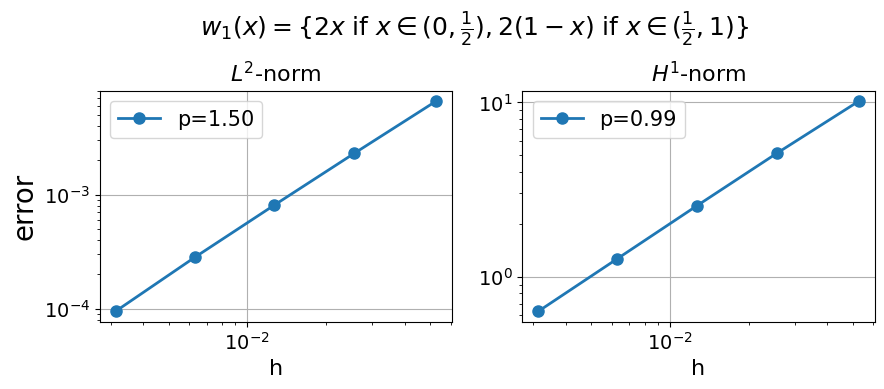

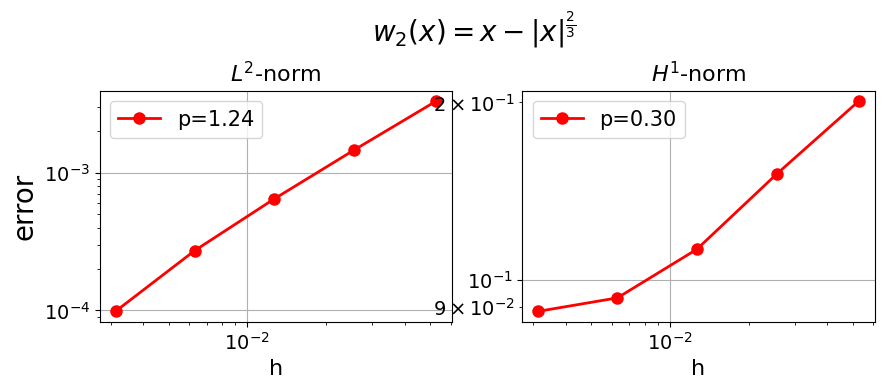

In [18]:
fig,axes = plt.subplots(1, 2, figsize=(10,3))

fig.suptitle(r"$w_1(x) = \{2x$ if $x \in (0, \frac{1}{2}), 2(1-x)$ if $x \in (\frac{1}{2}, 1)\}$", fontsize=18, y=1.15)

h,e,o = converge(F_w1,w1,dw1,norm="L2")

axes[0].set_title(r"$L^2$-norm", fontsize=16)
axes[0].loglog(h,e,'o-', label='p={:.2f}'.format(o))
axes[0].grid('on')
axes[0].set_xlabel('h', fontsize=16)
axes[0].set_ylabel('error', fontsize=20)
axes[0].legend(fontsize=15)

h,e,o = converge(F1,u1,du1,norm="H1")

axes[1].set_title(r"$H^1$-norm", fontsize=16)
axes[1].loglog(h,e,'o-', label='p={:.2f}'.format(o))
axes[1].grid('on')
axes[1].set_xlabel('h', fontsize=16)
axes[1].legend(fontsize=15)

plt.savefig("Convergence_w1.png", bbox_inches='tight')
fig.show()

h,e,o = converge(F_w2,w2,dw2,norm="L2")

fig,axes = plt.subplots(1, 2, figsize=(10,3))

fig.suptitle(r"$w_2(x) = x-|x|^{\frac{2}{3}}$", fontsize=20, y=1.15)

axes[0].set_title(r"$L^2$-norm", fontsize=16)
axes[0].loglog(h,e,'o-', label='p={:.2f}'.format(o), color="red")
axes[0].grid('on')
axes[0].set_xlabel('h', fontsize=16)
axes[0].set_ylabel('error', fontsize=20)
axes[0].legend(fontsize=15)

h,e,o = converge(F_w2,w2,dw2,norm="H1")

axes[1].set_title(r"$H^1$-norm", fontsize=16)
axes[1].loglog(h,e,'o-', label='p={:.2f}'.format(o), color="red")
axes[1].grid('on')
axes[1].set_xlabel('h', fontsize=16)
axes[1].legend(fontsize=15)

plt.savefig("Convergence_w2.png", bbox_inches='tight')
fig.show()

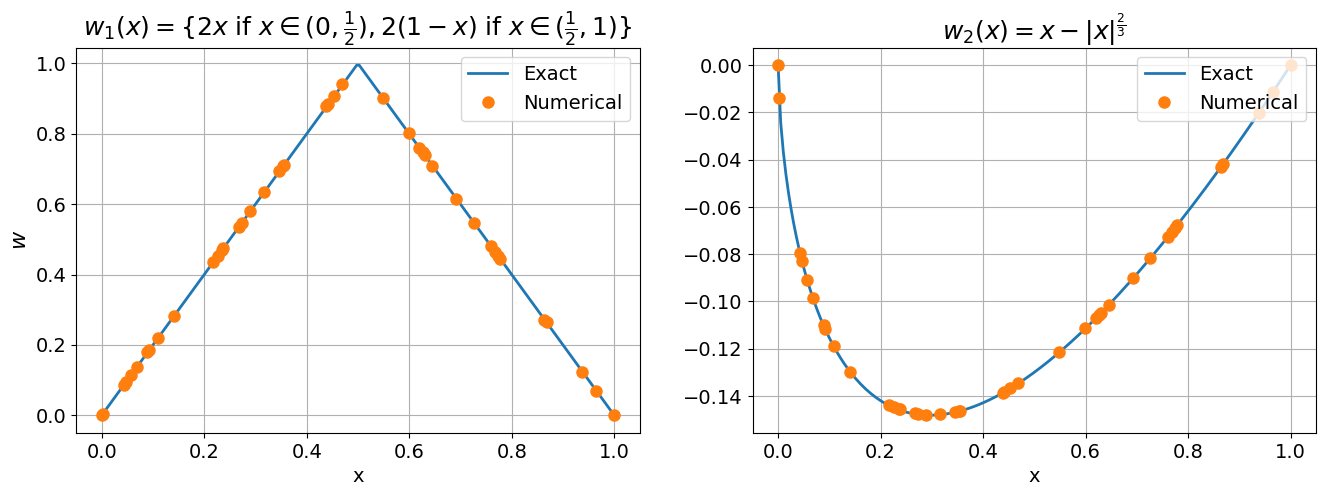

In [19]:
def u_2e(x):
    return x**(-1/4)

def du_2e(x):
    return 1/4 * x**(-5/4)

def ddu_2e(x):
    return 5/16 * x**(-9/4)

def f_2e(x):
    return - a * ddu_2e(x) + b * du_2e(x) + c * u_2e(x)

def F_2e(x, i, nodes):
    return f_2e(x) * phi(x, i, nodes)

a,b,c = 1,1,1
Xk = np.around(np.concatenate(([0],np.sort(np.random.random(40)),[1])), decimals=3)  # For printing out smaller A-matrix
Mi = len(Xk)                     # Number of nodes
T = np.ndarray.transpose(np.array([Xk[:-1],Xk[1:]])) # Set of elements/triangulation
H = Xk[1:]-Xk[:-1]               # Element sizes
Mk = Mi-1                        # Number of elements
A = assemble(Xk,H)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
x = np.linspace(0,1,200)

#Note: the random seed might result in divide-by-zero errors, in this case change the seed
RHS = setup_RHS(Xk,H,w1,F_w1)
U = np.linalg.solve(A,RHS)
U = np.concatenate(([w1(0)],U,[w1(1)]))

axes[0].set_title(r"$w_1(x) = \{2x$ if $x \in (0, \frac{1}{2}), 2(1-x)$ if $x \in (\frac{1}{2}, 1)\}$", fontsize=18)
axes[0].plot(x,w1(x),Xk,U,'o')
axes[0].legend(['Exact','Numerical'],loc=1)
axes[0].set_xlabel('x')
axes[0].set_ylabel(r"$w$", fontsize=16)

RHS = setup_RHS(Xk,H,w2,F_w2)
U = np.linalg.solve(A,RHS)
U = np.concatenate(([w2(0)],U,[w2(1)]))

axes[1].set_title(r"$w_2(x) = x-|x|^{\frac{2}{3}}$", fontsize=18)
axes[1].plot(x,w2(x),Xk,U,'o')
axes[1].legend(['Exact','Numerical'],loc=1)
axes[1].set_xlabel('x')

plt.savefig("2d_plots.png", bbox_inches="tight")
fig.show()



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0c79c791-f9f1-4616-ba40-29682d8e6f45' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>